# RustKit Learn
### CIS 1905 Rust Final Project
#### Marwan Achi, Rose Wang

For this project, we implemented the following methods in Rust to emulate the commonly used Python library SKLearn.
- Preprocessing:
    - Scaler
    - Imputer
- Supervised
    - Ridge Regression
    - With the following Regression Metrics:
        - $R^2$
        - MSE
- Unsupervised
    - KMeans
    - PCA

After implementing the methods in Rust, we created Python bindings using `maturin` and `PyO3` to use these methods and classes as a library in Python, called `rustkit`. To do so, we implemented converter functions that converted `numpy` matrices and vectors into `nalgebra` matrices and vectors, handling generic types and null values.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### 1. Benchmarking
We tested our implementation's performance in comparison to `sklearn`'s performance by measuring runtime across increasing input size in the following ways:
- `sklearn` method runtime: using wallclock time from the function call to when it returns in Python. See `python/logs/sklearn_benchmarking.csv` for raw data.
- `rustkit` method runtime: using wallclock time from the function call to when it returns in Python, including the full process of converting to/from Rust/Python objects. See `python/logs/rustkit_benchmarking.csv` for raw data.
- `rustkit` Rust internal runtime: using wallclock time from the function call to when the function returns in Rust, excluding all Python interoperability computation. See `python/logs/timing_log.csv` for raw data.

All Python benchmarking was done for 50 iterations. Input matrices ranged from 10 to 1000 rows and 2 to 50 columns. We ran two tests, one where we fixed the number of features (at 10) and varied the number of examples, and one where we fixed the number of examples (at 1000) and varied the number of features.

In [2]:
# read in benchmark logs
rustkit_python = pd.read_csv("logs/rustkit_benchmarking.csv", sep=",", header=None, names=["function", "nrows", "ncols", "avg_time"])
rustkit_rust = pd.read_csv("logs/timing_log.csv", sep=",", header=None, names=["function", "nrows", "ncols", "time"])
sklearn_python = pd.read_csv("logs/sklearn_benchmarking.csv", sep=",", header=None, names=["function", "nrows", "ncols", "avg_time"])

In [3]:
rustkit_python["library"] = "rustkit python"
rustkit_rust["library"] = "rustkit rust"
sklearn_python["library"] = "sklearn"

split_index = 7 * 7 * 50
rustkit_rust_rows = rustkit_rust[:split_index].copy()
rustkit_rust_cols = rustkit_rust[split_index:].copy()

# aggregate rustkit_rust
rustkit_rust_rows = rustkit_rust_rows.groupby(["function", "nrows", "ncols", "library"]).agg({"time": "mean"}).reset_index()
rustkit_rust_rows["avg_time"] = rustkit_rust_rows["time"]
rustkit_rust_rows.drop(columns=["time"], inplace=True)

rustkit_rust_cols = rustkit_rust_cols.groupby(["function", "nrows", "ncols", "library"]).agg({"time": "mean"}).reset_index()
rustkit_rust_cols["avg_time"] = rustkit_rust_cols["time"]
rustkit_rust_cols.drop(columns=["time"], inplace=True)

In [4]:
# split logs by row iteration and col iteration
split_index = 7 * 7
rustkit_python_rows = rustkit_python[:split_index].copy()
rustkit_python_cols = rustkit_python[split_index:].copy()
sklearn_python_rows = sklearn_python[:split_index].copy()
sklearn_python_cols = sklearn_python[split_index:].copy()

rustkit_python_rows["dim"] = rustkit_python_rows[["nrows", "ncols"]].max(axis=1)
rustkit_python_cols["dim"] = rustkit_python_cols[["nrows", "ncols"]].min(axis=1)
rustkit_rust_rows["dim"] = rustkit_rust_rows[["nrows", "ncols"]].max(axis=1)
rustkit_rust_cols["dim"] = rustkit_rust_cols[["nrows", "ncols"]].min(axis=1)
sklearn_python_rows["dim"] = sklearn_python_rows[["nrows", "ncols"]].max(axis=1)
sklearn_python_cols["dim"] = sklearn_python_cols[["nrows", "ncols"]].min(axis=1)

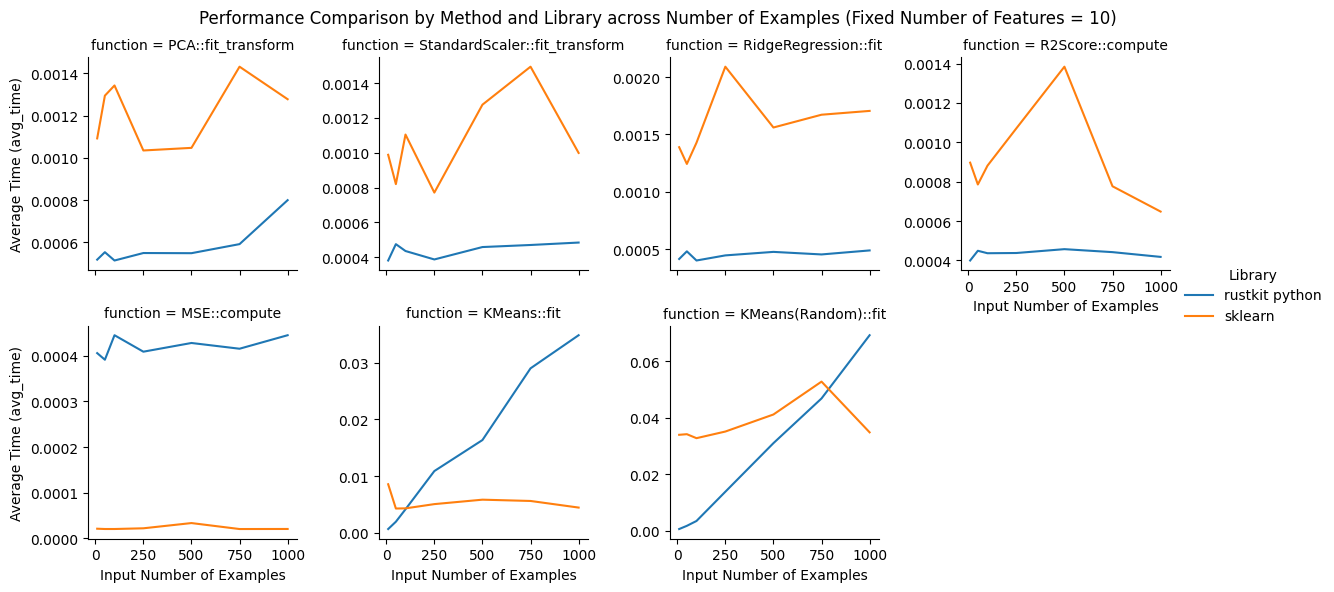

In [5]:
# rust python and sklearn comparison, fixed ncols = 10
graph = pd.concat([rustkit_python_rows, sklearn_python_rows])

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    sharey=False,
    col_wrap=4,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Examples", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Examples (Fixed Number of Features = 10)")

plt.show()

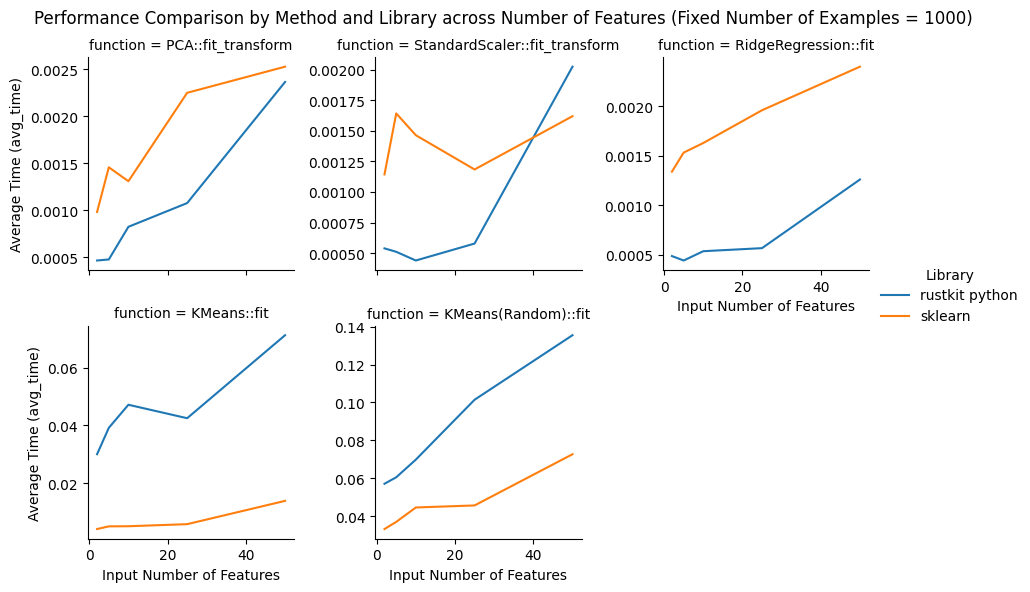

In [6]:
# rust python and sklearn comparison, fixed nrows = 1000
graph = pd.concat([rustkit_python_cols, sklearn_python_cols])
graph = graph[graph["dim"] != 1]

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    sharey=False,
    col_wrap=3,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Features", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Features (Fixed Number of Examples = 1000)")

plt.show()

Knowing that some of the difference in runtime can be attributed to the Python bindings themselves, let's see how the Python interop impacted performance by comparing rustkit's runtime from Python vs. Rust.

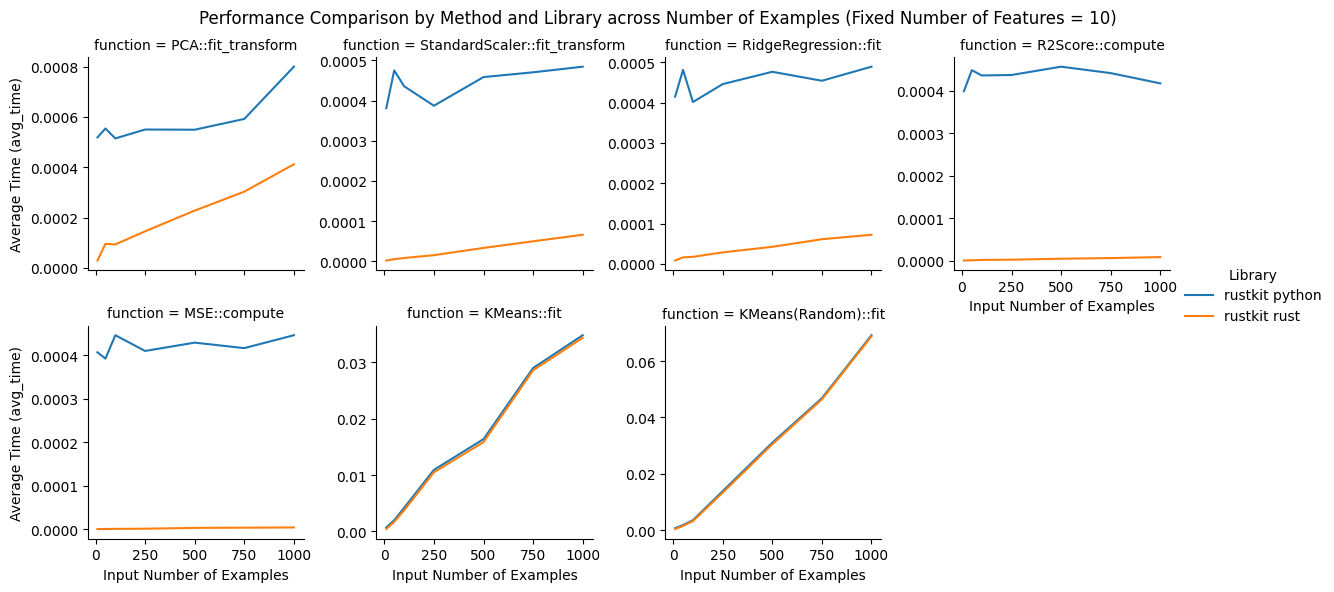

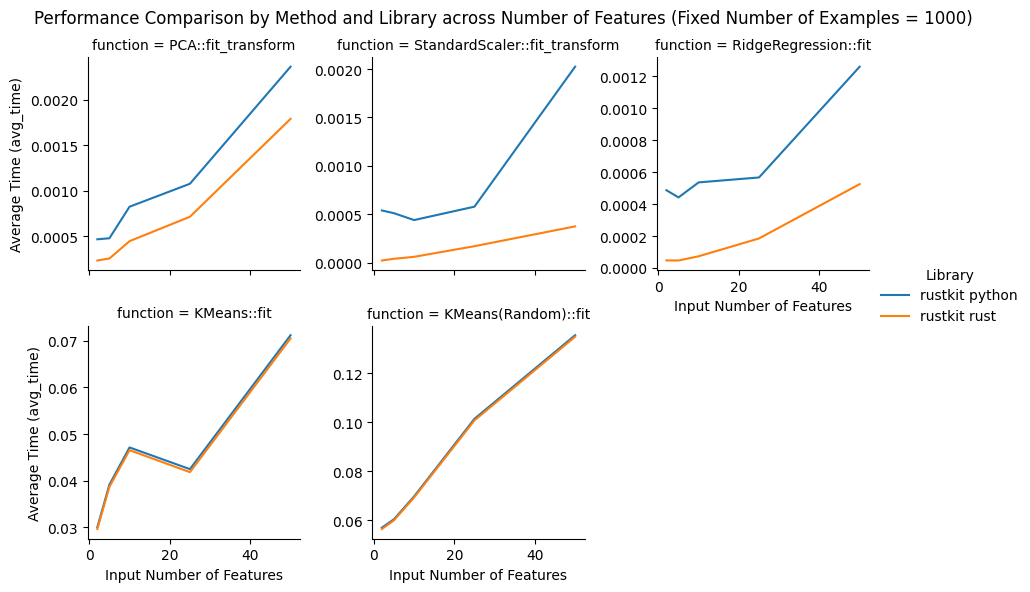

In [7]:
# Plot rustkit python vs rustkit rust
graph = pd.concat([rustkit_python_rows, rustkit_rust_rows])

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    col_wrap=4,
    sharey=False,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Examples", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Examples (Fixed Number of Features = 10)")

plt.show()

graph = pd.concat([rustkit_python_cols, rustkit_rust_cols])
graph = graph[graph["dim"] != 1]

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    sharey=False,
    col_wrap=3,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Features", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Features (Fixed Number of Examples = 1000)")

plt.show()


Python bindings and conversion to/from Rust only starts to take up significant amounts of runtime by input sizes of around 750 examples and 25 features. The slowdown increases most noticeably as features scales. This is expected because way that memory is laid out in Python (row-major), involving the copying of more columns. Now, let's assess runtime differences between `sklearn` and `rustkit`'s underlying Rust runtime.

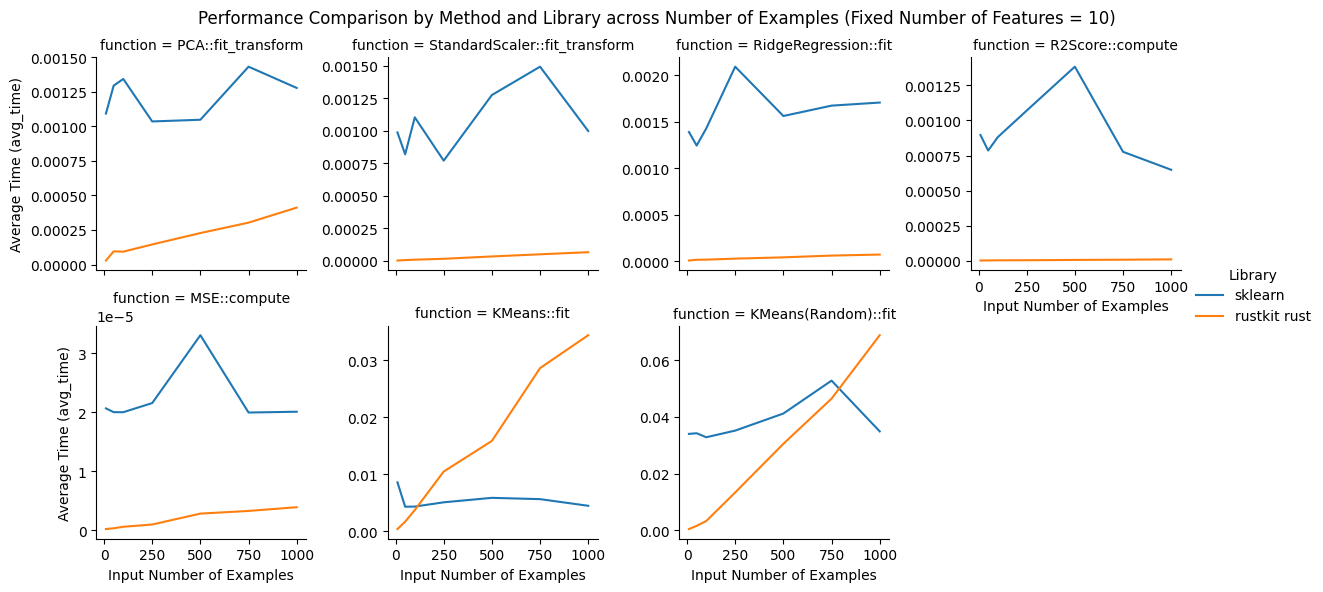

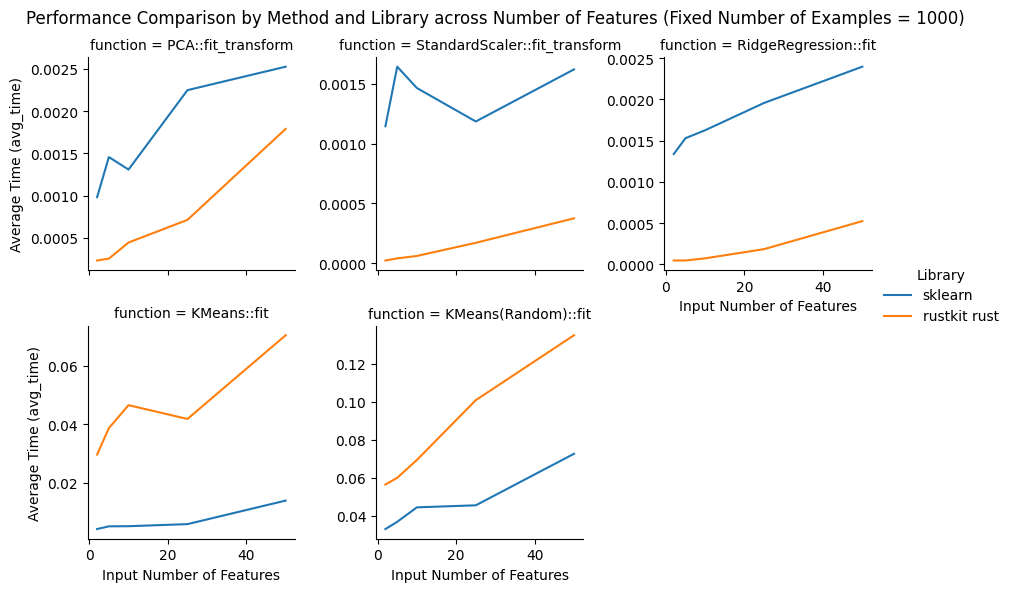

In [8]:
# Plot rustkit rust vs sklearn
graph = pd.concat([sklearn_python_rows, rustkit_rust_rows])

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    col_wrap=4,
    sharey=False,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Examples", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Examples (Fixed Number of Features = 10)")

plt.show()

graph = pd.concat([sklearn_python_cols, rustkit_rust_cols])
graph = graph[graph["dim"] != 1]

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    sharey=False,
    col_wrap=3,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Features", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Features (Fixed Number of Examples = 1000)")

plt.show()

Our implementations of PCA, Standard Scaler, Ridge Regression runs faster than the `sklearn` implementations of these methods. However, KMeans is where the `sklearn` beats out `rustkit`. This is because in `sklearn`, the `KMeans` implementation parallelized across multiple CPU cores to achieve faster runtimes. This can be seen as the number of examples scales.

Future work would include doing more work to optimize our Rust code by parallelizing computation.

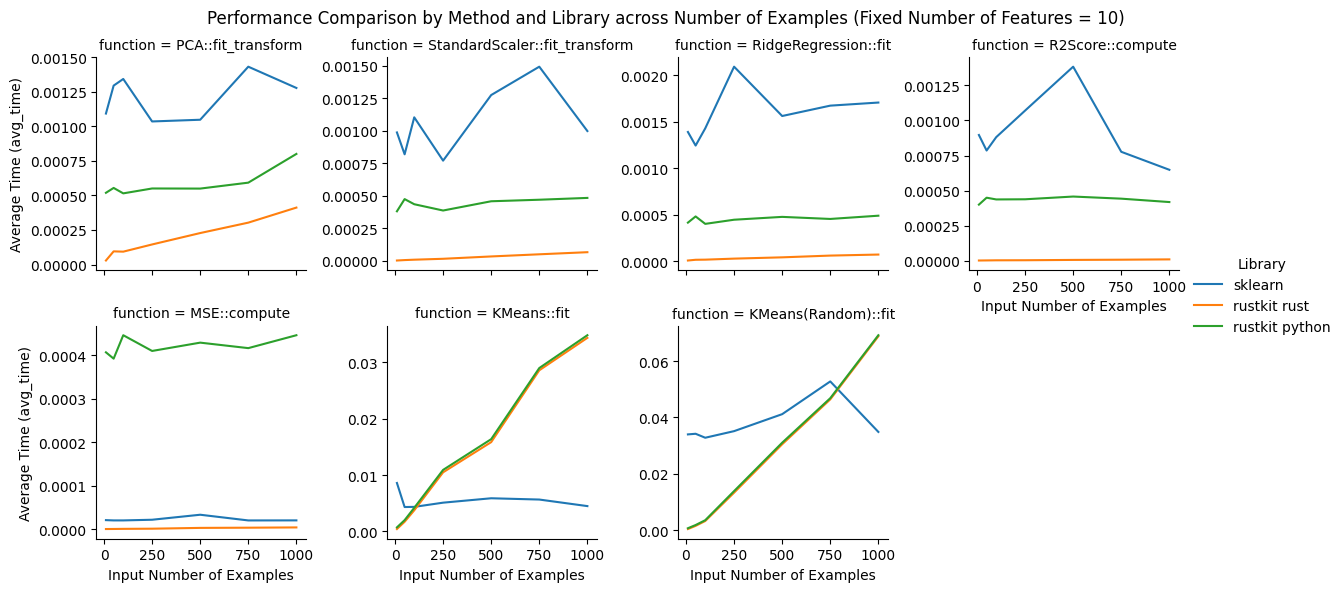

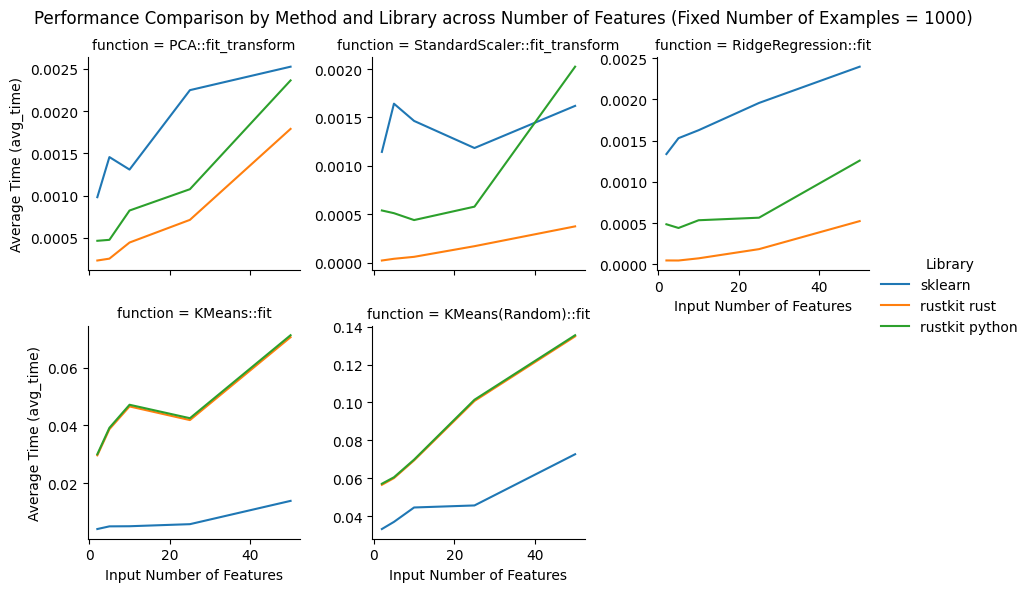

In [9]:
# Plot rustkit rust vs sklearn
graph = pd.concat([sklearn_python_rows, rustkit_rust_rows, rustkit_python_rows])

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    col_wrap=4,
    sharey=False,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Examples", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Examples (Fixed Number of Features = 10)")

plt.show()

graph = pd.concat([sklearn_python_cols, rustkit_rust_cols, rustkit_python_cols])
graph = graph[graph["dim"] != 1]

g = sns.FacetGrid(
    graph,
    col="function",
    palette="tab10",
    sharey=False,
    col_wrap=3,
    height=3
)

g.map_dataframe(sns.lineplot, x="dim", y="avg_time", hue="library")

g.add_legend(title="Library")
g.set_axis_labels("Input Number of Features", "Average Time (avg_time)")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Performance Comparison by Method and Library across Number of Features (Fixed Number of Examples = 1000)")

plt.show()

### 2. Unit Tests
We tested our implementation fo **correctness** by comparing `rustkit` outputs to `sklearn` outputs.
Specifically, we assessed correctness on the following inputs:
- Inputs of size 1
- Square inputs
- Rectangular inputs
- Large inputs
- Inputs with only negative values
- Inputs with only positive values
- Inputs with both positive and negative values

In [10]:
import rustkit
import unit_tests as tests

In [11]:
tests.test_square_input()
print("\n")
tests.test_large_input()
print("\n")
tests.test_negative_input()
print("\n")
tests.test_mixed_input()
print("\n")
tests.test_single_input()

SQUARE INPUT
Standard Scaler correctness test passed!
Ridge Regression correctness test passed!
PCA correctness test passed!
KMeans - KMeans++ correctness test passed!
KMeans - KMeans++ inertia correctness test passed!
KMeans - Random correctness test passed!
KMeans - Random inertia correctness test passed!


LARGE INPUT
Standard Scaler correctness test passed!
Ridge Regression correctness test passed!
R² correctness test passed!
MSE correctness test passed!
PCA correctness test passed!
KMeans - KMeans++ correctness test passed!
KMeans - KMeans++ inertia correctness test passed!
KMeans - Random correctness test passed!
KMeans - Random inertia correctness test passed!
Imputer correctness test passed!


NEGATIVE INPUT
Standard Scaler correctness test passed!
Ridge Regression correctness test passed!
R² correctness test passed!
MSE correctness test passed!
PCA correctness test passed!
KMeans - KMeans++ correctness test passed!
KMeans - KMeans++ inertia correctness test passed!
KMeans - Ra

We tested our **Python bindings** for correctness by comparing the outputs of `main.rs` with `test.py`, where we tested each method for expected rust functionality. We also tested the conversion to/from Rust/Python in isolation by converting in isolation.

In [19]:
def test_converter_vector():
    input_vector = np.array([1.0, 2.0, 3.0, 4.0])
    result = rustkit.converter_vector_test(input_vector)
    
    result_vector = np.array(result)
    
    print("=" * 77)
    print("VECTOR TEST")
    print("=" * 77)
    print("Input vector:")
    print(input_vector)
    print("Result vector:")
    print(result_vector)
    assert np.array_equal(input_vector, result_vector), "Test failed! Input and output vectors are not equal."
    print("Vector test passed!")

def test_converter_matrix():
    input_matrix = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    
    result = rustkit.converter_matrix_test(input_matrix)
    
    result_matrix = np.array(result)
    
    print("=" * 77)
    print("MATRIX TEST")
    print("=" * 77)
    print("Input matrix:")
    print(input_matrix)
    print("Result matrix:")
    print(result_matrix)
    assert np.array_equal(input_matrix, result_matrix), "Test failed! Input and output matrices are not equal."
    print("Matrix test passed!")

def test_converter_opt_matrix():
    print("=" * 77)
    print("NULL VAL MATRIX TEST")
    print("=" * 77)
    input_matrix = np.array([[1.0, np.nan, 3.0], [4.0, 5.0, np.nan]])
    
    result = rustkit.converter_matrix_opt_test(input_matrix)
    
    result_matrix = np.array(result)
    
    print("Input matrix:")
    print(input_matrix)
    print("Result matrix:")
    print(result_matrix)
    
    for i in range(input_matrix.shape[0]):
        for j in range(input_matrix.shape[1]):
            if np.isnan(input_matrix[i][j]):
                assert np.isnan(result_matrix[i][j]), "Test failed! NaN values are not equal."
            else:
                assert input_matrix[i][j] == result_matrix[i][j], "Test failed! Values are not equal."
    print("Null value matrix test passed!")

In [20]:
test_converter_matrix()
print("\n")
test_converter_vector()
print("\n")
test_converter_opt_matrix()

MATRIX TEST
Input matrix:
[[1. 2. 3.]
 [4. 5. 6.]]
Result matrix:
[[1. 2. 3.]
 [4. 5. 6.]]
Matrix test passed!


VECTOR TEST
Input vector:
[1. 2. 3. 4.]
Result vector:
[1. 2. 3. 4.]
Vector test passed!


NULL VAL MATRIX TEST
Input matrix:
[[ 1. nan  3.]
 [ 4.  5. nan]]
Result matrix:
[[ 1. nan  3.]
 [ 4.  5. nan]]
Null value matrix test passed!


### 3. Using `rustkit` with real datasets

In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

np.random.seed(42)
missing_mask = np.random.rand(*X.shape) < 0.1  # Randomly make 10% of the data missing
X_with_missing = X.mask(missing_mask)

print("\nMissing values after introducing NaNs:")
print(X_with_missing.isnull().sum())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_with_missing, y, test_size=0.2, random_state=42)


Missing values after introducing NaNs:
MedInc        2045
HouseAge      2062
AveRooms      2132
AveBedrms     2112
Population    2039
AveOccup      2016
Latitude      2015
Longitude     2125
dtype: int64


In [15]:
# Implementation in sklearn
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('regressor', Ridge())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")

R^2: 0.3786
MSE: 0.8143


In [16]:
# implementation in Rustkit
import rustkit

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

imputer = rustkit.Imputer("mean")
scaler = rustkit.StandardScaler()
pca = rustkit.PCA()
regressor = rustkit.RidgeRegression(1, True)

X_train_imputed = imputer.fit_transform(X_train_np)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_train_pca = pca.fit_transform(X_train_scaled, 5)
regressor.fit(X_train_pca, y_train_np)

y_pred = regressor.predict(pca.transform(scaler.transform(imputer.transform(X_test_np))))

r2 = rustkit.R2Score.compute(y_test_np, y_pred)
mse = rustkit.MSE.compute(y_test_np, y_pred)

print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")

R^2: 0.3786
MSE: 0.8143


### 4. Rust Features and Crates Used
The main new crates and language features used were:
- `nalgebra`: for flexible matrix and vector implementations
- `numpy`: Rust objects closely related to Python NumPy objects, used as an interlayer between `nalgebra` and Python
- `pyo3`: Provides Rust bindings for Python

In Python, we used `maturin` to build crates as python packages.

#### 4.1 Brief overview of `nalgebra`





##### Overview & Matrix types
nalgebra is a general-purpose linear algebra library written for rust. The library revolves around 3 general matrix types (and their vector analogs):

- DMatrix: This is a dynamically sized matrix, where both the number of rows and columns are determined at runtime. Internally, it uses `VecStorage<T, Dyn, Dyn>`, which allocates memory on the heap to accommodate varying sizes. 

- SMatrix: This represents a statically sized matrix with dimensions known at compile time. It utilizes `ArrayStorage<T, R, C>`, storing data on the stack for fixed sizes, leading to potential performance benefits due to reduced heap allocations. 

- OMatrix: A more generic matrix type that can represent both statically and dynamically sized matrices. It employs the `Owned<T, R, C>` storage type, which, through type aliases, resolves to either ArrayStorage or VecStorage based on the specified dimensions. This flexibility allows OMatrix to adapt its storage strategy according to whether the dimensions are known at compile time or need to be dynamic.

Since our data science classes will never know the dimensions of input data at compile time, this rules out SMatrix. By the same reasoning, even though OMatrix would support dynamic dimensions, we went with DMatrix as the default representation format for out data. This is because we expect the vast majority of matrix sizes to be unknown at compile time, and so we can default to heap allocation, and maintain code clarity regarding this through the DMatrix type.

##### Sample methods and traits used
Throughout this project, we used a variety of features of nalgebra to handle our data in matrix form and perform operations. Here are some of the most commonly used / interesting methods and trait implementations in our project:

- `column_iter()` and `row_iter()`: These methods allow us to iterate over the matrices either in row or column order, where the iterator returns a column or row vector (respectively) at each step.
- `from_rows()` and `from_columns()`: Construction of a matrix from collections of equally sized row or column vectors.
- `+,-,*`: Matrices and vectors in nalgebra implement `Add`, `Sub` and `Mul` (for the correct dimension), which made it pleasant to directly perform matrix operations using these operators.
- `svd()`: Performs a Singular Value Decomposition on a matrix and stores the decomposition matrices. This was used in our PCA class, and more generally is an example of the variety of Linear Algebra methods implemented by nalgebra that ended up being useful to us. 

#### 4.2 Using `pyo3` and `maturin` to package `rustkit`
At its core, we used `nalgebra` to implement the actual Rust classes and methods that run the computation of the ML algorithms. To expose these Rust classes and methods to Python via a Python package we:
1. Leveraged `pyo3` to create bindings. 
    - Used decorators`#[pyclass]`, `#[pymethods]`, `#[pyfunction]` to expose classes, methods, and functions callable from Python
    - Used `PyValueError` to send errors from Rust to Python
    - Python types, including `PyFloat`. See [here](https://pyo3.rs/main/conversions/tables) for a mapping of Python types to Rust types
        ```rust
        #[pyclass]
        pub struct StandardScaler {
            means: Option<DVector<f64>>,
            std_devs: Option<DVector<f64>>,
        }

        #[pymethods]
        impl StandardScaler {
            /// Creates a new `StandardScaler` instance.
            #[new]
            pub fn new() -> Self {
                StandardScaler {
                    means: None,
                    std_devs: None,
                }
            }

            // Wrapper for the fit method
            pub fn fit(&mut self, data: PyReadonlyArray2<f64>) -> PyResult<()> {
                let rust_data = python_to_rust_dynamic_matrix(&data);
                let shape = rust_data.shape();
                let result = log_function_time(
                    || self.fit_helper(&rust_data),
                    "StandardScaler::fit",
                    shape.0,
                    shape.1,
                );
                match result {
                    Ok(_) => Ok(()),
                    Err(e) => Err(PyValueError::new_err(e.to_string())),
                }
            }
        }
        ```
2. `numpy` to convert Rust `nalgebra` objects into Python's `numpy` objects so that Python objects could be usable in Rust and vice versa, where `PyArray` and `PyReadonlyArray` are `numpy` types.

    ```rust
    pub fn python_to_rust_opt_dynamic_matrix(array: &PyReadonlyArray2<f64>) -> DMatrix<Option<f64>> {
        // Convert a NumPy array to nalgebra::DMatrix
        let matrix = array.as_array();
        let shape = matrix.shape();
        let rows = shape[0];
        let cols = shape[1];
        let elements = matrix.iter().cloned().collect::<Vec<_>>();
        DMatrix::from_iterator(
            rows,
            cols,
            elements.into_iter().map(python_to_rust_opt_float),
        )
    }
    pub fn rust_to_python_dynamic_matrix<
        T: ToPyObject + Clone + std::fmt::Debug + std::cmp::PartialEq + numpy::Element + 'static,
    >(
        py: Python,
        matrix: DMatrix<T>,
    ) -> PyResult<Py<PyArray2<T>>> {
        let shape = matrix.shape();
        let rows = shape.0;
        let cols = shape.1;
        let transposed_matrix = matrix.transpose();
        let array = Array2::from_shape_vec((rows, cols), transposed_matrix.data.into());
        match array {
            Ok(arr) => Ok(PyArray2::from_array(py, &arr).into()),
            Err(e) => Err(pyo3::exceptions::PyValueError::new_err(format!(
                "Array creation failed: {}",
                e
            ))),
        }
    }
    ```
3. `maturin` to package the `rustkit` crate into a Python library.
    - Our Rust project, `rustkit` follows the following directory structure:
        ```
        rustkit
        ├───rustkit
        │   ├───__init__.py
        │   └───**compiled package**
        ├───src
        │   ├───preprocessing
        │   ├───supervised
        │   ├───testing
        │   ├───unsupervised
        │   ├───lib.rs
        │   └───main.rs
        ├───Cargo.toml
        ├───pyproject.toml
        └───target
        ```
    - To package the crate, 
        1. Create a Python environment that is at least 3.10, and `pip intall maturin`
        2. If you don't have the `rustkit/rustkit/` folder, create it.
        3. To build the package, run `maturin develop` from the `rustkit/` directory
            - This command compiles the local Rust crate into a Python module and installs it into your local Python environment, in the `rustkit/rustkit/` folder
            - Run `maturin develop --release` if you want the build to be 
        4. Within the `rustkit/rustkit/` folder, create `__init__.py`
            - Put the following in `__init__.py`:
                ```python
                from .rustkit import *
                from .rustkit import __all__
                ```
        5. Now, you should be able to call methods from `rustkit` in Python using `from rustkit import StandardScaler` or `import rustkit`

### 5. Reflection on Project and Rust as a whole
#### Writing Rust code
Writing the source code for these data science algorithms in Rust was quite enjoyable. The iterator syntax and map functions were pleasant to use. Additionally the use of traits to implement matrix operations made working with linear algebra straightforward, and compile-time 
errors with matrix sizing etc. ensured that we implemented algorithms correctly. As an example this `assign_labels` function from the KMeans implementation felt particularly elegant in Rust:

```rust
    // Assigns each data point to the nearest centroid
    fn assign_labels(&self, data: &DMatrix<f64>, centroids: &DMatrix<f64>) -> DVector<usize> {
        // Map each data point to the index of its closest centroid
        DVector::from_iterator(
            data.nrows(),
            data.row_iter().map(|data_point| {
                // For the current data point, calculate the distance to each centroid
                let closest_centroid = centroids
                    .column_iter()
                    .enumerate() // Keep track of the centroid index
                    .map(|(centroid_idx, centroid)| {
                        // Compute the squared Euclidean distance to the centroid
                        let distance = (data_point - centroid.transpose()).norm_squared();
                        (centroid_idx, distance)
                    })
                    // Find the centroid with the smallest distance
                    .min_by(|(_, dist_a), (_, dist_b)| dist_a.partial_cmp(dist_b).unwrap())
                    .unwrap(); // Unwrap is safe when centroids is non-empty

                closest_centroid.0 // Return the index of the closest centroid
            }),
        )
    }
    
    


#### Null data
One downside of working with Rust as a source for Python code was dealing with null entries in our data. In particular, since `f64` is non-nullable in Rust, it was unclear how to deal with Python data that had null entries. 

Thankfully, nalgebra does allow `Option<f64>` as an entry type for matrices, though most methods and traits don't apply to such matrices. This allowed us to write the `Simple_Imputer` class which takes potentially null data and imputes it to return a matrix of only non-null `f64` values. This approach is a double-edged sword: while it enforces good data science practice by forcing the user to deal with null entries, it means that any user calling our library from Python is forced to go through an imputation stage if they have any null values in their data.


#### Python Bindings and Packaging
Creating Python bindings and packaging the crate was made a lot simpler using `pyo3` and `maturin`. The surrounding ecosytem around Rust is quite impressive, and made the development process for Rust/Python interoperation significantly easier. From this experience, it definitely made me more interested in building similar projects in the future.

The main challenges with this portion of the project were mainly in dealing with the Python portions of the project. We had a hard time configuring Python environments across operating systems (Mac vs Windows) and using `maturin` to compile the crate across different devices. We also struggled quite a bit with the creation of `pyproject.toml` and `__init_.py` to unwrap the compiled Python project. This contrasted significantly with the ease of use with `cargo`.